In [17]:
import os
import json
import glob
import collections
import random


from stable_baselines3.common import results_plotter
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm


plt.rc('pdf',fonttype = 42)
plt.rc('ps',fonttype = 42)

In [18]:
SMALL_SIZE = 25
MEDIUM_SIZE = 30
BIGGER_SIZE = 40
LINEWIDTH = 5


OURS = "Deconfounded"
NAIVEBC = "Naive BC"
ORACLE = "Oracle"
DAGGER = "DAgger"
TRUE_INTERVENTIONAL = "True interventional"
TRUE_CONDITIONAL = "True conditional"
EXPERT = 'Expert'
GAIL = "GAIL"

# From https://colorbrewer2.org/#type=qualitative&scheme=Set1&n=5
colors = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00']
r = lambda: random.randint(0,255)
L2C = collections.defaultdict(lambda : f"#{r():02x}{r():02x}{r():02x}")


L2C.update({
    OURS: '#e41a1c',
    NAIVEBC: "#75c1ff",
    ORACLE: 'black',
    DAGGER: 'grey',
    TRUE_INTERVENTIONAL: 'black',
    TRUE_CONDITIONAL: 'black',
    EXPERT: 'black',
    GAIL: 'orange',
})
styles = ["-", "--", "-.", ":", "-"]
rs = lambda: random.randint(0,len(styles)-1)
L2LS = collections.defaultdict(lambda: styles[rs()])
L2LS.update({
    OURS: "solid",
    NAIVEBC: "solid",
    ORACLE: 'solid',
    DAGGER: 'dashed',
    TRUE_INTERVENTIONAL: 'dashed',
    TRUE_CONDITIONAL: 'dashdot',
    EXPERT: 'solid',
    GAIL: 'dashdot',
})

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('lines', linewidth=LINEWIDTH)

In [19]:
expdirs = [
    "/data/antlia/risrio/dil/logs/20231022_ant_dil_6_seeds",
    "/data/antlia/risrio/dil/logs/20231022_ant_bc_6_seeds",
    "/data/antlia/risrio/dil/logs/20231022_ant_dagger_6_seeds",
    "/data/antlia/risrio/dil/logs/20231023_ant_gail_6_seeds",
]

In [28]:
train_dfs = []
eval_dfs = []
for ed in expdirs:
    logdirs = glob.glob(os.path.join(ed, "**", "args.json"), recursive=True)
    for ld in logdirs:
        with open(ld, "r") as f:
            args = json.load(f)
        label = ""
        if args.get("deconfounding"):
            label = OURS
        elif args.get("dagger"):
            label = DAGGER
        elif "target" in args["imitator_feature_extractor_obs_keys"]:
            label = ORACLE
        elif "disc_lr" in args:
            label = "GAIL"
            if args['disc_lr'] < 1e-4: continue
            if "permutation" in args["imitator_feature_extractor_obs_keys"]:
                label += " ORACLE"
        else:
            label = NAIVEBC

        dirname = os.path.dirname(ld)
        try:
            train_df = pd.read_csv(os.path.join(dirname, "train", "progress.csv"))
        except:
            print(f"couldn't load {dirname}")
        for k, v in args.items():
            train_df[k] = str(v)
        train_df["label"] = label
        train_dfs.append(train_df)
        try:
            eval_df = pd.read_csv(os.path.join(dirname, "eval", "progress.csv"))
            eval_df["label"] = label
            for k, v in args.items():
                eval_df[k] = str(v)
            eval_dfs.append(eval_df)
        except:
            print(f"couldn't load {dirname}")

train_df = pd.concat(train_dfs)
eval_df = pd.concat(eval_dfs)


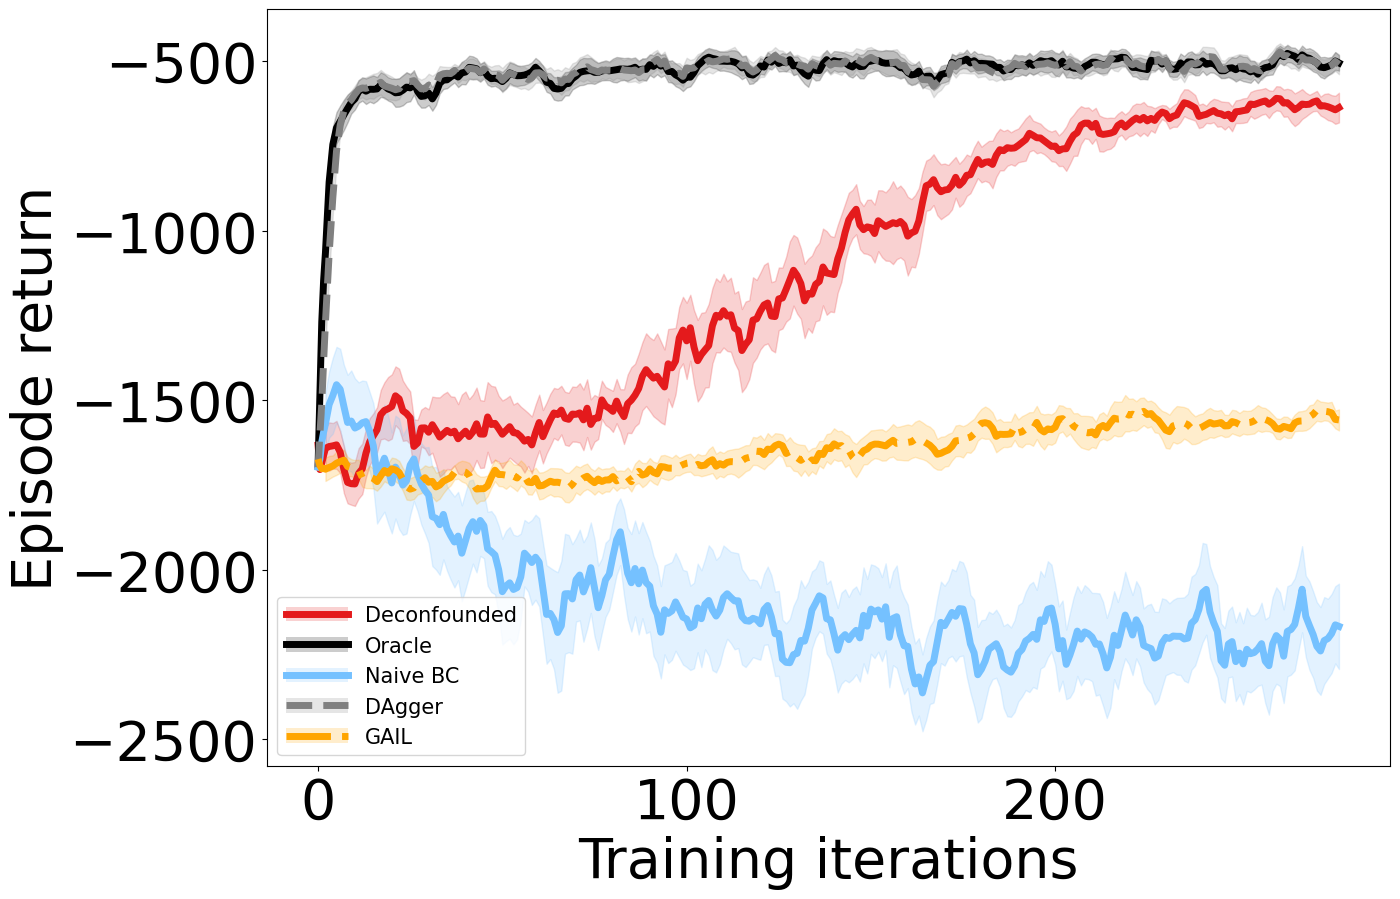

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10,))
col = 'bc/rewards'
x = 'train/step'
window = 5

legend_items, legend_labels = [], []


data = eval_df

for label in data.label.unique():
    df = data[data.label == label]
    df = df[df[col].isna() == False]
    df[x] = df.index
    mean = df[df.label == label][[col, x, 'seed']].groupby(['seed']).rolling(window, min_periods=1).mean().groupby([x]).mean().reset_index()
    n_seeds = len(df.seed.unique())
    st_mean = df[df.label == label][[col, x, 'seed']].groupby(['seed']).rolling(window, min_periods=1).mean().groupby([x]).mean().reset_index()
    st_err  = df[df.label == label][[col, x, 'seed']].groupby([x]).std().rolling(window).mean().reset_index() / np.sqrt(n_seeds)
    line = ax.plot(mean[x].tolist(), mean[col], label=label, color=L2C[label], linestyle=L2LS[label])
    low = st_mean[col] - st_err[col]
    high = st_mean[col] + st_err[col]
    ax.fill_between(st_mean[x].tolist(), low, high, alpha=0.2, color=L2C[label])
    proxy = ax.fill(np.NaN, np.NaN, c=L2C[label], alpha=0.2, linewidth=0.0)
    legend_items.append((line[0], proxy[0]))
    legend_labels.append(label)

ax.set_xlabel("Training iterations")
ax.set_ylabel("Episode return")
_ = ax.legend(legend_items, legend_labels, handlelength=3, fontsize=15
              )
plt.tight_layout()